In [1]:
import json
import os
import glob
import warnings
from pathlib import Path
from pennylane import numpy as np
import pickle
import pennylane as qml
from sympy import default_sort_key
import torch
from discopy.quantum.pennylane import to_pennylane, PennyLaneCircuit
from inspect import signature
from noisyopt import minimizeSPSA
import random
import collections
from scipy.special import kl_div

from utils import *

this_folder = os.path.abspath(os.getcwd())

nshot=10000
nparam=100

In [38]:
num_of_bins = 75
bins_list = [i/(num_of_bins) for i in range(num_of_bins + 1)]
bins_x = [bins_list[1]+bins_list[i] for i in range(num_of_bins - 1)]


def P_harr(l, u, N):
    return (1-l)**(N-1)-(1-u)**(N-1)


#Harr histogram
P_harr_hist = [P_harr(bins_list[i], bins_list[i+1], 2) for i in range(num_of_bins)]

In [3]:
# Select workload
workload = "execution_time"
#workload = "cardinality"

# Select workload size
#workload_size = "small"
#workload_size = "medium"
#workload_size = "large"
workload_size = "main"

classification = 1
layers = 1
single_qubit_params = 3
n_wire_count = 1

# Access the selected circuits
path_name = this_folder + "//simplified-JOB-diagrams//" + workload + "//" + workload_size + "//circuits//" + str(classification) + "//" + str(layers) + "_layer//" + str(single_qubit_params) + "_single_qubit_params//" + str(n_wire_count) + "_n_wire_count//"

training_circuits_paths = glob.glob(path_name + "training//[0-9]*.p")
validation_circuits_paths = glob.glob(path_name + "validation//[0-9]*.p")
test_circuits_paths = glob.glob(path_name + "test//[0-9]*.p")

In [4]:
all_circuits = read_diagrams(training_circuits_paths)
validation_circuits = read_diagrams(validation_circuits_paths)
all_circuits = read_diagrams(test_circuits_paths)
#all_circuits.update(validation_circuits)
#all_circuits.update(test_circuits)

In [5]:
tot_qubits = 10
dev = qml.device("default.qubit", wires=tot_qubits, shots=nshot)

qml_circuits = []
symbols = set([elem for c in all_circuits for elem in all_circuits[c].free_symbols])
symbols = list(sorted(symbols, key=default_sort_key))

for circuit_diagram in all_circuits.values():
    pennylane_circuit = to_pennylane(circuit_diagram)
    params = pennylane_circuit.params
    pennylane_wires = pennylane_circuit.wires
    ops = pennylane_circuit.ops
    param_symbols = [[sym[0].as_ordered_factors()[2]] if len(sym) > 0 else [] for sym in params]
    symbol_to_index = {}

    for sym in param_symbols:
        if len(sym) > 0:
            symbol_to_index[sym[0]] = symbols.index(sym[0])

    @qml.qnode(dev)
    def qml_circuit(circ_params):
        for op, param, wires in zip(ops, param_symbols, pennylane_wires):
            if len(param) > 0:
                param = param[0]
                op(circ_params[symbol_to_index[param]], wires = wires)
            else:
                op(wires = wires)
        return qml.sample()
    
    qml_circuits.append(qml_circuit)

#all_qml_circuits = qml.QNodeCollection(qml_circuits)

In [6]:
def post_select_circuit_samples(circuit_samples):
    selected_samples = []
    post_select_array = np.array([0]*(circuit_samples[0].size - 1))
    for circuit_sample in circuit_samples:
        if np.array_equal(circuit_sample[1:], post_select_array):
            if circuit_sample[0] == 1:
                selected_samples.append(1)
            else:
                selected_samples.append(0)
    return selected_samples

In [7]:
fidelity=[]
circuit = qml_circuits[0]
for x in range(nparam):
    params = [2*np.pi*random.uniform(0, 1) for i in range(len(symbols))]
    result = circuit(params)
    post_selected_result = post_select_circuit_samples(result)
    res = collections.Counter(post_selected_result)

    if 0 in res:
        ratio = res[0]/nshot
    else:
        ratio = 0
        
    fidelity.append(ratio)

In [45]:
print(fidelity)

[ 241591.9    187904.81    26843.545  120795.95    53687.09    13421.772
       0.     107374.18   483183.8         0.      13421.772       0.
   80530.64    13421.772  147639.5     13421.772  187904.81        0.
       0.      13421.772   67108.87   161061.28        0.      40265.32
   40265.32        0.      13421.772   53687.09    13421.772   40265.32
   26843.545       0.          0.      26843.545       0.     107374.18
  147639.5    241591.9         0.     120795.95    26843.545   13421.772
   93952.41    53687.09   201326.6     13421.772       0.      13421.772
   40265.32        0.    1892470.     255013.69   442918.5     40265.32
   93952.41        0.          0.     402653.2    362387.88   228170.14
   13421.772       0.      13421.772       0.          0.     174483.05
   53687.09   120795.95    40265.32  1127428.9     93952.41        0.
   67108.87        0.      53687.09        0.          0.          0.
   26843.545       0.     255013.69    26843.545   53687.09    53687.

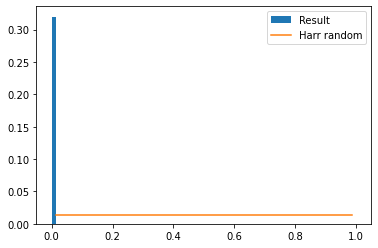

In [44]:
import numpy
weights = numpy.ones_like(fidelity)/float(len(fidelity))
fidelity = numpy.array([(2**9)*x for x in fidelity])
plt.hist(fidelity, bins=bins_list, weights=weights, label='Result', range=[0, 1])
plt.plot(bins_x, P_harr_hist[:-1], label='Harr random')
plt.legend(loc='upper right')
plt.show()

In [43]:
P_I_hist = numpy.histogram(fidelity, bins = bins_list, weights = weights, range=[0, 1])[0]
kl_pq = kl_div(P_I_hist, P_harr_hist)
print('KL(P || Q): %.3f nats' % sum(kl_pq))

TypeError: histogram requires ndarray or scalar arguments, got <class 'list'> at position 1.